# Car_brand_classification

### The dataset which was used in this project is [Stanford Car Dataset][1]. It contains of approximately 16k images divided into 196 classes. The main problem which I faced in this project is overfitting due to the large number of classes and each class has only 40 images. I tried **Mobilenet, Resnet-50** but still facing overfitting issue. **Efficientnet** is later selected and fine-tuned for the task. It eventually performed considerably better with the accuracy of ~95% on trainning set and 73% on validation set. 

### Read more regarding Efficientnet in [here][2].

[1]:https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder
[2]: https://arxiv.org/abs/1905.11946

### Visualizing dataset

In [123]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import glob
from keras.preprocessing.image import ImageDataGenerator, load_img
%matplotlib inline

In [124]:
image_visulaization =ImageDataGenerator(rescale=1/255)
image_visulaization.flow_from_directory("car_data/train/")

Found 8144 images belonging to 196 classes.


In [125]:
train_folder = glob.glob("car_data/train/*")
for i, name in enumerate(train_folder):
    print("%i."%i, name[15:],"\n")

0. Acura Integra Type R 2001 

1. Acura RL Sedan 2012 

2. Acura TL Sedan 2012 

3. Acura TL Type-S 2008 

4. Acura TSX Sedan 2012 

5. Acura ZDX Hatchback 2012 

6. AM General Hummer SUV 2000 

7. Aston Martin V8 Vantage Convertible 2012 

8. Aston Martin V8 Vantage Coupe 2012 

9. Aston Martin Virage Convertible 2012 

10. Aston Martin Virage Coupe 2012 

11. Audi 100 Sedan 1994 

12. Audi 100 Wagon 1994 

13. Audi A5 Coupe 2012 

14. Audi R8 Coupe 2012 

15. Audi RS 4 Convertible 2008 

16. Audi S4 Sedan 2007 

17. Audi S4 Sedan 2012 

18. Audi S5 Convertible 2012 

19. Audi S5 Coupe 2012 

20. Audi S6 Sedan 2011 

21. Audi TT Hatchback 2011 

22. Audi TT RS Coupe 2012 

23. Audi TTS Coupe 2012 

24. Audi V8 Sedan 1994 

25. Bentley Arnage Sedan 2009 

26. Bentley Continental Flying Spur Sedan 2007 

27. Bentley Continental GT Coupe 2007 

28. Bentley Continental GT Coupe 2012 

29. Bentley Continental Supersports Conv. Convertible 2012 

30. Bentley Mulsanne Sedan 2011 

31. BMW 1 

In [126]:
temp = glob.glob("%s/*.jpg" %train_folder[1])

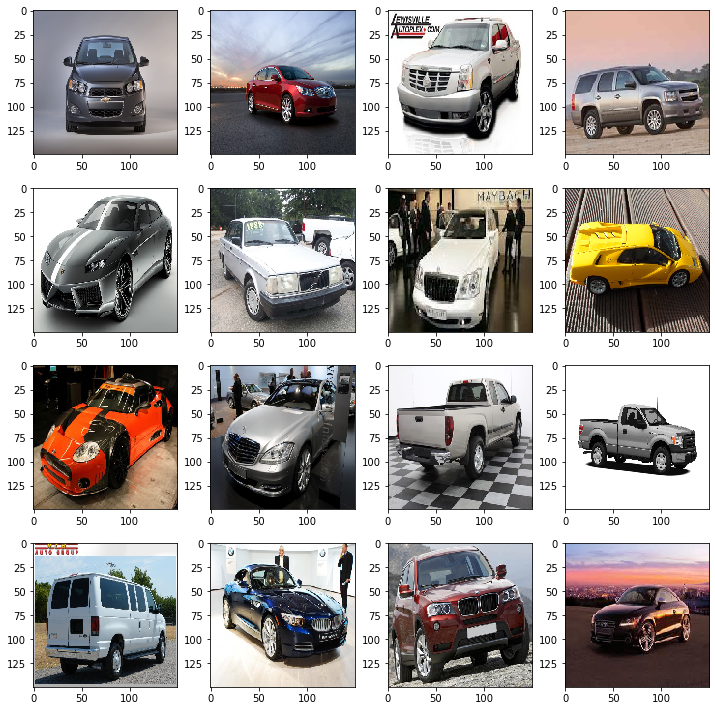

In [128]:
w=10
h=10
fig=plt.figure(figsize=(w, h))
columns = 4
rows = 4
fig_list= []

for i in range(1, columns*rows +1):
    rand1 = np.random.randint(196)
    rand2 = np.random.randint(32)
    fig_list.append(fig.add_subplot(rows, columns, i))
    temp = glob.glob("%s/*.jpg" %train_folder[rand1])
    img = load_img(temp[rand2],target_size=(150,150))
    plt.imshow(img)
    
plt.tight_layout(True)   
plt.show()

### Data augmentation

In [14]:
image_gen = ImageDataGenerator(rotation_range=30,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              rescale=1/255,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              fill_mode="nearest",
                              validation_split=0.2) # set validation split

print(image_gen.flow_from_directory("car_data/train/"))
print(image_gen.flow_from_directory("car_data/test/"))


Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


### Create a model with pre-trained efficientnet layers and user-created head layers

In [15]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from efficientnet.keras import EfficientNetB0

In [16]:
def build_finetune_model(base_model, dropout, num_classes):
    x = base_model.output
    x = AveragePooling2D((5,5))(x)
    x = Flatten()(x)
    x = Dropout(dropout)(x)

    predictions = Dense(num_classes, activation="softmax")(x)

    finetune_model = Model(inputs = base_model.input, outputs = predictions)

    return finetune_model

In [17]:
input_shape=(224,224,3)

base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)

finetune_model = build_finetune_model(base_model, 0.7, 196)

finetune_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

finetune_model.summary()

checkpoint_filepath = 'best_weights.h5'

my_checkpointer = ModelCheckpoint(filepath=checkpoint_filepath,
                               verbose=1, save_best_only=True)

W1109 19:21:12.492522  4520 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [18]:
batch_size = 64

train_image_gen = image_gen.flow_from_directory("car_data/train/",
                                                target_size=input_shape[:2],
                                                batch_size=batch_size,
                                                class_mode="categorical")

valid_image_gen = image_gen.flow_from_directory("car_data/test/",
                                                target_size=input_shape[:2],
                                                batch_size=batch_size,
                                                class_mode="categorical")

Found 8144 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


### Train model

In [0]:
result = finetune_model.fit_generator(train_image_gen,epochs=20,steps_per_epoch=len(train_image_gen),
                           validation_data=valid_image_gen,validation_steps=len(valid_image_gen),callbacks=[my_checkpointer],verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
128/128 [==============================] - 391s 3s/step - loss: 5.0796 - acc: 0.0284 - val_loss: 4.3200 - val_acc: 0.1162

Epoch 00001: val_loss improved from inf to 4.31999, saving model to best_weights.h5
Epoch 2/20
128/128 [==============================] - 348s 3s/step - loss: 3.5289 - acc: 0.1980 - val_loss: 3.3986 - val_acc: 0.2791

Epoch 00002: val_loss improved from 4.31999 to 3.39856, saving model to best_weights.h5
Epoch 3/20
128/128 [==============================] - 358s 3s/step - loss: 2.2079 - acc: 0.4255 - val_loss: 2.4992 - val_acc: 0.4761

Epoch 00003: val_loss improved from 3.39856 to 2.49920, saving model to best_weights.h5
Epoch 4/20
128/128 [==============================] - 359s 3s/step - loss: 1.5149 - acc: 0.5905 - val_loss: 2.4204 - val_acc: 0.5169

Epoch 00004: val_loss improved from 2.49920 to 2.42042, saving model to best_weights.h5
Epoch 5/20
128/128 [

### Plot training history

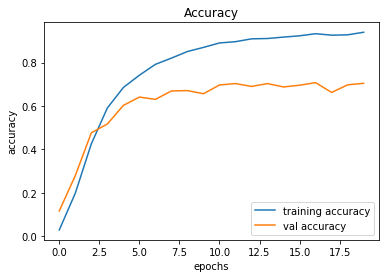

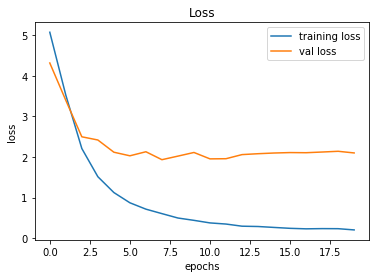

In [0]:
plt.figure(0)
plt.plot(result.history['acc'], label='training accuracy')
plt.plot(result.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


### Evaluate the model on test set

In [20]:
finetune_model.load_weights("best_weights.h5")

In [21]:
input_shape=(224,224,3)

batch_size = 128

test_image_gen = image_gen.flow_from_directory("car_data/test/",
                                                target_size=input_shape[:2],
                                                batch_size=batch_size,
                                                class_mode="categorical")


#pred = finetune_model.predict_generator(test_image_gen,steps=len(test_image_gen),verbose=1)

loss, acc = finetune_model.evaluate_generator(test_image_gen, steps=len(test_image_gen), verbose=0)
print("Accuracy on test datasetis: {}%".format(str(np.around(acc*100,2))))

Found 8041 images belonging to 196 classes.
63/63 [==============================] - 1507s 24s/step
Accuracy on test datasetis: 75.61%


In [50]:
def predict_from_image(image):
    test_image = cv2.imread(image)
    test_image = cv2.resize(test_image,(224,224))
    test_image = test_image/255
    test_image = test_image.reshape(1,224,224,3)
    
    prediction = finetune_model.predict(test_image)
    
    return np.where(prediction[0]==prediction[0].max())[0][0]

### Loading brand names form csv file

In [68]:
import pandas as pd
car_name_list =pd.read_csv("names.csv")
car_name_list

,Car brand
0,Acura Integra Type R 2001
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012
...,...
191,Volkswagen Golf Hatchback 1991
192,Volkswagen Golf Hatchback 2012
193,Volvo 240 Sedan 1993
194,Volvo C30 Hatchback 2012


In [77]:
car_name_list.loc[5][0]

'Acura ZDX Hatchback 2012'

### Predict a random image from test dataset

Audi TTS Coupe 2012


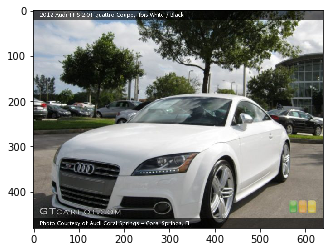

In [118]:
import glob 
test_path_folder = glob.glob("car_data/test/*")
rand_folder = np.random.randint(len(test_path_folder))
test_path_image = glob.glob(test_path_folder[rand_folder] +"/*.jpg")

rand_image = np.random.randint(len(test_path_image))
test_image = test_path_image[rand_image]

index = predict_from_image(test_image)
print(car_name_list.loc[index][0])

show_image = load_img(test_image)
plt.imshow(show_image)


### Plot multiple prediction of  random images from test dataset

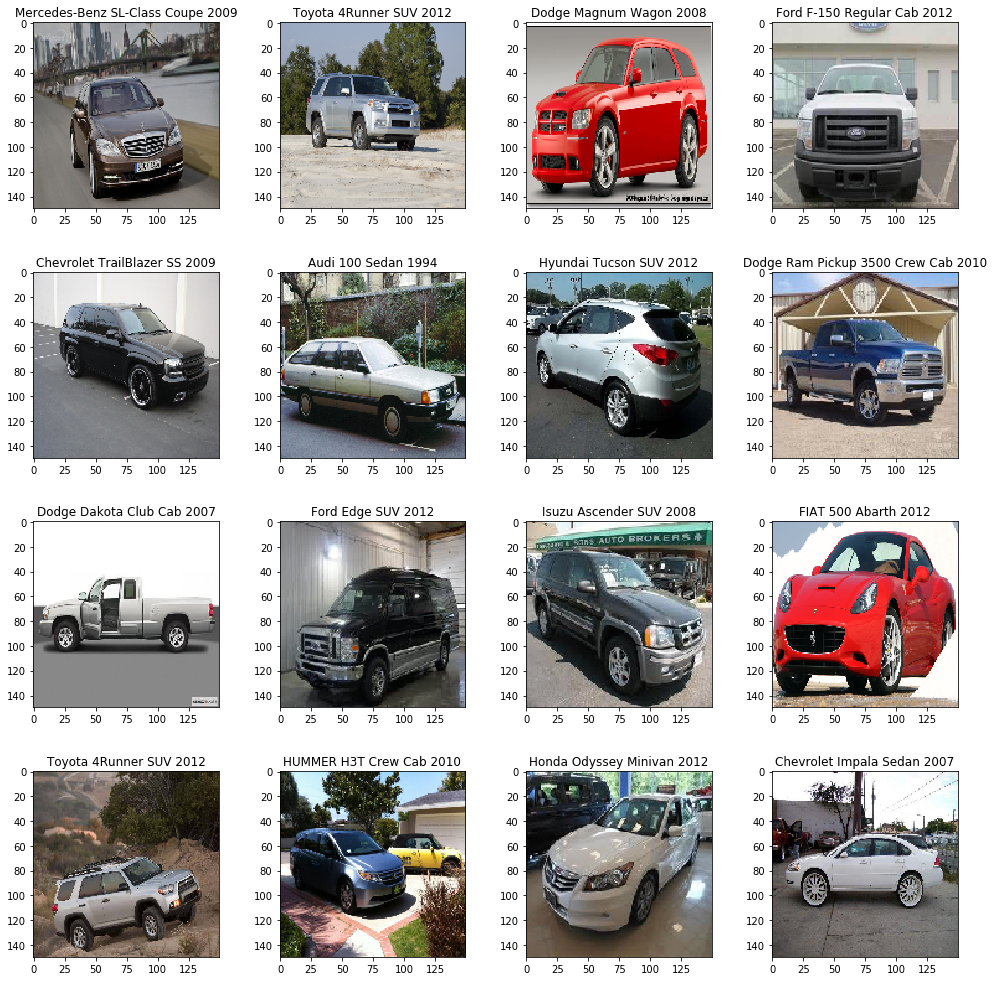

In [121]:
fig = plt.figure(figsize=(14,14))
cols =4
rows = 4
fig_list=[]

for i in range(1,cols*rows+1):
    # initialize random paths to predicting picutres
    test_path_folder = glob.glob("car_data/test/*")
    rand_folder = np.random.randint(len(test_path_folder))
    test_path_image = glob.glob(test_path_folder[rand_folder] +"/*.jpg")
    rand_image = np.random.randint(len(test_path_image))
    test_image = test_path_image[rand_image]
    
    # predict and extract car band name
    index = predict_from_image(test_image)
    title = car_name_list.loc[index][0]
    
    # Show our prediction
    fig_list.append(fig.add_subplot(rows,cols,i))
    fig_list[-1].set_title(title)
    show_image = load_img(test_image,target_size=(150,150))
    plt.imshow(show_image)
    
plt.tight_layout(True)
plt.show()
  


### Conclusion

- Although efficientnet showed a positive result, I was not able to imporve the accuracy to more than 70% on the test set. I tried optimizer Adam with learning from 1e-3 to 1e-5 but still while the accuracy on the trainning set obtains 99%, this value on test set can not be improved.

- To improve the accuracy of the test set, more data need to be added into the trainning set. 

# The end!